<center>
    COMP4600/5300 - Reinforcement Learning

# Homework 5 - Temporal Difference

### Due: Wednesday, October 14th 11:59 pm
    
</center>

Student Name: ______________________ 

The purpose of this project is to study different properties of Temporal Difference methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt


## Part I
The following Windy Gridworld includes a crosswind running upward through the middle of the grid. The strength of wind is shown under each column that you should use for shifting. The goal is to reach the goal state G from the start state S. This is an undiscounted episodic task, with constant rewards of -1 until the goal state is reached.
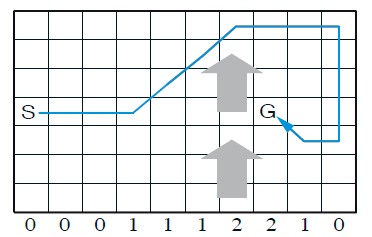


## Part I
Implement SARSA (on-policy TD control) using $\varepsilon$–greedy policy with parameters $\varepsilon=0.1, \alpha=0.5$, and $Q_0 (s,a)=0$ for all $s,a$. Apply your implementation to the windy gridworld in the following scenarios:


**(a)** In this scenario, the agent’s action set includes four moves (i.e. Up, Down, Right, Left). Plot the number of episodes vs. time steps (similar to graph in page 130). Then calculate the average episode length. 

**(b)** In this scenario, the agent has access to King’s moves (eight actions). You need to define a new action set and re-run the experiment in previous scenario. Plot the number of episodes vs. time steps. Then calculate the average episode length.

**(c)** In this scenario, you need to add a ninth action that causes no movement at all other than that caused by the wind. Plot the number of episodes vs. time steps. Then calculate the average episode length.

**(d)** In this scenario, the agent has access to King’s moves (eight actions). Assume that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous part, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal. Plot the number of episodes vs. time steps. Then calculate the average episode length.

**Note:** all four plots should be shown in one figure for comparison.



In [2]:
def plot_all(data, eps_lens, title, label):
    plt.figure(figsize=(12, 12))
    plt.title(title)
    for i, plot in enumerate(data, start=1):
        plt.plot(plot, label=label.format(i, np.mean(eps_lens[i-1])))
    plt.legend()
    plt.show()
    

In [3]:
def my_argmax(array):
    """
    return argmax and break ties
    """
    max_ = np.nanmax(array)
    indx = [i for i in range(len(array)) if array[i] == max_]
    return np.random.choice(indx)


In [4]:
def wind_det(s):
    """
    return deterministic wind vector
    """
    wind = np.zeros(2, dtype=np.int)
    col = s[1]
    if 2 < col < 9:
        wind[0] -= 1
        if col in (6, 7):
            wind[0] -= 1
    return wind


def wind_stoch(s):
    """
    return stochastic wind vector
    """
    stoch = np.random.choice((-1, 0, 1))
    stoch = np.array([stoch, 0])
    wind = wind_det(s + stoch)
    return wind


In [5]:
def mask_actions_4(Q):
    """
    put nan in indeces of unallowed actions. this way my_argmax does not consider them 
    """
    for i in range(ROWS):
        for j in range(COLS):
            if i == 0:
                # no up
                Q[1, i, j] = np.nan
            elif i == S.shape[0] - 1:
                # no down
                Q[3, i, j] = np.nan
            if j == 0:
                # no left
                Q[2, i, j] = np.nan
            elif j == S.shape[1] - 1:
                # no right
                Q[0, i, j] = np.nan
    return Q


def mask_actions_8_9(Q):
    """
    put nan in indeces of unallowed actions. this way my_argmax does not consider them 
    """
    for i in range(ROWS):
        for j in range(COLS):
            if i == 0:
                # no up
                Q[[1, 2, 3], i, j] = np.nan
            elif i == S.shape[0] - 1:
                # no down
                Q[[5, 6, 7], i, j] = np.nan
            if j == 0:
                # no left
                Q[[3, 4, 5], i, j] = np.nan
            elif j == S.shape[1] - 1:
                # no right
                Q[[7, 0, 1], i, j] = np.nan
    return Q


In [6]:
def transition(s, a, wind):
    """
    transition function
    """
    s_p = s + a + wind(s)
    terminal = np.array_equal(s_p, ST)
    reward = -1
    s_p[0] = max(s_p[0], 0)  # stick at border
    return reward, s_p, terminal


def get_e_greedy_action(Q, s, eps=0.1):
    """
    get action with e-greedy policy
    """
    explore = np.random.choice((True, False), p=(eps, 1 - eps))
    if explore == True:
        indecis = np.where(~np.isnan(Q[:, s[0], s[1]]))[0]
        return np.random.choice(indecis)
    return my_argmax(Q[:, s[0], s[1]])


In [7]:
def sarsa(Q, A, k=180, eps=0.1, alpha=0.5, wind=wind_det):
    """
    implement SARSA. 
    return a list for the number episodes finished at each time step
    return another list for the time steps taken by each episode
    """
    epi_per_t = []
    len_episodes = np.zeros(k)
    for episode in range(k):
        s = np.copy(S0)
        a = get_e_greedy_action(Q, s, eps=0.1)
        while True:
            len_episodes[episode] += 1
            
            r, s_p, terminal = transition(s, A[a], wind=wind)
            a_p = get_e_greedy_action(Q, s_p, eps=eps)

            Q[a, s[0], s[1]] = Q[a, s[0], s[1]] + \
                                alpha * (r + Q[a_p, s_p[0], s_p[1]] - Q[a, s[0], s[1]])
                
            s, a = s_p, a_p
            
            epi_per_t.append(episode)
            if terminal:
                break

    return epi_per_t, len_episodes
        

In [8]:
ROWS = 7
COLS = 10

S = np.zeros((ROWS, COLS), dtype=np.int)
S0 = np.array((3, 0), dtype=np.int)
ST = np.array((3, 7), dtype=np.int)
K = 175  # num episodes

A4 = np.array(((0, 1), (-1, 0), (0, -1), (1, 0)), dtype=np.int)
Q4 = np.zeros((4, ROWS, COLS))

right, up, left, down = A4
A8 = np.array((right, right + up, up, up + left, left, left + down, down, down + right), dtype=np.int)
Q8 = np.zeros((8, ROWS, COLS))

A9 = np.insert(A8, 8, (0, 0), axis=0)
Q9 = np.zeros((9, ROWS, COLS))


In [9]:
Q4 = mask_actions_4(Q4)
data0, ep_lens0 = sarsa(Q4, A4, k=K)


In [10]:
Q8 = mask_actions_8_9(Q8)
data1, ep_lens1 = sarsa(np.copy(Q8), A8, k=K)


In [11]:
Q9 = mask_actions_8_9(Q9)
data2, ep_lens2 = sarsa(Q9, A9, k=K)


In [12]:
data3, ep_lens3 = sarsa(np.copy(Q8), A8, k=K, wind=wind_stoch)


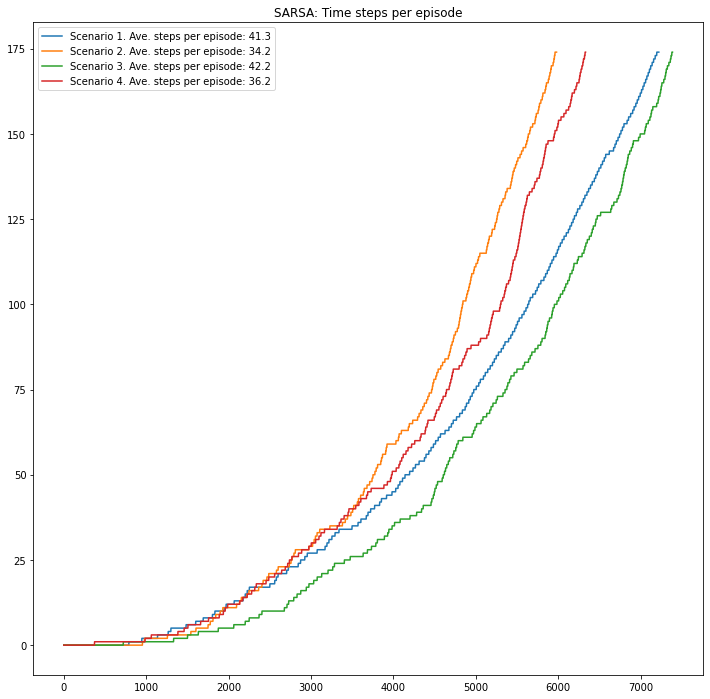

In [13]:
data = [data0, data1, data2, data3]
ep_lens = [ep_lens0, ep_lens1, ep_lens2, ep_lens3]
title = "SARSA: Time steps per episode"
label = "Scenario {}. Ave. steps per episode: {:.1f}"

plot_all(data, ep_lens, title, label)


## Part II
Consider the following gridworld with four actions (up, down, right, and left). If the action takes the agent off the gird, the agent stays in the same state. In each non-terminating step, the agent receives a random reward of -12 or +10 with equal probability. The reward for reaching the goal state is +5 and the episode ends when the agent reaches the goal.

Use $\varepsilon$–greedy policy with $\varepsilon(s) = \frac{1}{\sqrt{n(s)}}$ where $n(s)$ is the number of times state $s$ has been visited, assuring infinite exploration in the limit which is a theoretical requirement for the convergence of both **Q-learning** and **Double Q-learning**. 
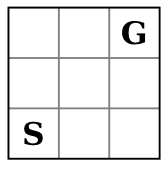

a. Implement **Q-learning** and **Double Q-learning** and apply them to this problem for 10,000 experiments using the learning rate $\alpha=\frac{1}{n(s,a)}$.

b. Plot the average reward per step vs. number of time steps averaged over 10,000 experiments. The length of an episode following the optimal policy is five actions, so the optimal average reward per step is +0.2. Plot this true value in your figure and see how close your algorithm gets to the true value.

c. Plot the maximal action value in the starting state $S$ (i.e. $max_a Q(s,a)$) averaged over 10,000 experiments. The optimal value of maximally valued action in the starting state is $5\gamma^4 - \sum_{k=0}^3 \approx 0.36$. Plot this true value in your figure and see how close your algorithm gets to the true value.

d. Repeat the experiments with $\alpha = \frac{1}{n(s,a)^{0.8}}$ and redo steps b and c.


**Note:** You should have four figures (average rewards and maximal action values for different learning rates, $2 \times 2$). 


In [14]:
def transition(s, a):
    """
    transition function
    """
    s_p = s + a
    s_p[0] = min(max(s_p[0], 0), ROWS - 1)  # stick at border
    s_p[1] = min(max(s_p[1], 0), COLS - 1)  # stick at border
    terminal = np.array_equal(s_p, ST)
    reward = 5 if terminal else np.random.choice((-12, 10))
    return reward, s_p, terminal


In [18]:
def qlearning(Q, A, k, alpha_p=1):
    Q = Q * 10000
    r_per_t = []
    steps_count = {}
    r_per_e = np.zeros(k)
    for episode in range(k):
        s = np.copy(S0)

        a_count = np.zeros_like(Q)  # count number of times an action was taken
        s_count = np.zeros_like(S)

        step = 0
        r_e = 0
        while True:
            try:
                steps_count[step] += 1
            except KeyError:
                steps_count[step] = 1

            s_count[s[0], s[1]] += 1

            eps = 1 / np.sqrt(s_count[s[0], s[1]])
            a = get_e_greedy_action(Q, s, eps=eps)

            a_count[a, s[0], s[1]] += 1

            r, s_p, terminal = transition(s, A[a])
            r_e += r

            alpha = 1 / (a_count[a, s[0], s[1]])**alpha_p
            error = r + np.max(Q[:, s_p[0], s_p[1]]) - Q[a, s[0], s[1]]
            Q[a, s[0], s[1]] += alpha * error 

            try:
                old = r_per_t[step]
            except IndexError:
                old = 0
                r_per_t.append(old)
            r_per_t[step] = old + (r - old) / steps_count[step] 

            step += 1
            if terminal == 1:
                break
            s = s_p
        r_per_e[episode] = r_e
    return Q, r_per_t, np.argmax(Q, axis=0), r_per_e


In [19]:
def double_qlearning(Q, A, k, alpha_p=1):
    Q1 = np.copy(Q)
    Q2 = np.copy(Q)
    Q = np.array((Q1, Q2))
    r_per_t = []
    steps_count = {}
    r_per_e = np.zeros(k)
    for episode in range(k):
        a_count = np.zeros_like(Q1)  # count number of times an action was taken
        s_count = np.zeros_like(S)
        s = np.copy(S0)

        step = 0
        r_e = 0
        while True:
            try:
                steps_count[step] += 1
            except KeyError:
                steps_count[step] = 1

            s_count[s[0], s[1]] += 1

            eps = 1 / np.sqrt(s_count[s[0], s[1]])
            a = get_e_greedy_action(Q1 + Q2, s, eps=eps)
            a_count[a, s[0], s[1]] += 1

            r, s_p, terminal = transition(s, A[a])
            r_e += r

            alpha = 1 / (a_count[a, s[0], s[1]])**alpha_p
            np.random.shuffle(Q)
            error = r + Q[1, my_argmax(Q[0, :, s_p[0], s_p[1]]), s_p[0], s_p[1]] - Q[0, a, s[0], s[1]]
            Q[0, a, s[0], s[1]] += alpha * error 
                
            s = s_p
            
            try:
                old = r_per_t[step]
            except IndexError:
                old = 0
                r_per_t.append(old)
            r_per_t[step] = old + (r - old) / steps_count[step]

            step += 1
            if terminal:
                break
        r_per_e[episode] = r_e

    return (Q[0] + Q[1])/2, r_per_t, np.argmax((Q[0] + Q[1])/2, axis=0), r_per_e

In [ ]:
ROWS = 3
COLS = 3

S = np.zeros((ROWS, COLS), dtype=np.int)
S0 = np.array((2, 0), dtype=np.int)
ST = np.array((0, 2), dtype=np.int)
K = 10_000  # num episodes

A = np.array(((0, 1), (-1, 0), (0, -1), (1, 0)), dtype=np.int)
Q = np.zeros((4, ROWS, COLS))
Q_0, ave_reward0, q, r_per_e = qlearning(Q=np.copy(Q), A=A, k=K, alpha_p=1)
# Q_1, ave_reward1, q, r_per_e = double_qlearning(Q=np.copy(Q), A=A, k=K, alpha_p=1)
# Q_2, ave_reward2, q = qlearning(Q=np.copy(Q), A=A, k=K, alpha_p=0.8)
# Q_3, ave_reward3, q, r_per_e = double_qlearning(Q=np.copy(Q), A=A, k=K, alpha_p=0.8)

In [ ]:
def plot_all(R_Qs1, R_Qs2, titles_1, titles_2):
    fig, (up, down) = plt.subplots(2,2, figsize=(15,15))
    for ax_up, ax_down, R_Q1, R_Q2, title1, title2 in zip(up, down, R_Qs1, R_Qs2, titles_1, titles_2):
        ax_up.plot(R_Q1)
        ax_up.set_title(title1, fontsize=14)
        ax_up.set_xlabel("Time Step")
        ax_up.set_ylabel("Average Reward")
        ax_up.axhline(y=0.2, color='r', linestyle='-', label="Optimal average reward per step")
        ax_up.legend()
        
        ax_down.plot(R_Q2)
        ax_down.set_xlabel("Time Step")
        ax_down.set_ylabel("Average Reward")
        ax_down.set_title(title2, fontsize=14)
        ax_down.axhline(y=0.2, color='r', linestyle='-', label="Optimal average reward per step")
        ax_up.legend()
        
    plt.tight_layout()
    plt.show()

In [ ]:
titles_1 = ["Average reward per time step.\nSingle Q Learning. Alpha power = 1", "Average reward per time step.\nDouble Q Learning. Alpha power = 1"]
titles_2 = ["Average reward per time step.\nSingle Q Learning. Alpha power = 0.8", "Average reward per time step.\nDouble Q Learning. Alpha power = 0.8"]
plot_all([ave_reward0, ave_reward1], [ave_reward2, ave_reward3], titles_1, titles_2)
# plot_all([ave_reward1], [ave_reward3], titles_1, titles_2)